# Model to ICEWS Events

In this analysis, I'm going to build a basic BDM model for the world based on COW alliance taus (with position = similarity to United States, to capture unipolarity) and see how predicted conflicts align with ICEWS events.

In [1]:
import copy
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations


import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from negotiation_model import *
from bdm_agent import *

## Load Alliance Data

In [3]:
start_year = 2004

In [4]:
alliance_dyads = pd.read_csv("/Users/dmasad/Data/COW/Alliances/alliance_v4.1_by_dyad_yearly.csv")
alliance_dyads = alliance_dyads[alliance_dyads.year==start_year]
alliance_dyads["Alliance"] = 0
alliance_dyads.loc[(alliance_dyads.entente==1),"Alliance"] = 1
alliance_dyads.loc[(alliance_dyads.nonaggression==1),"Alliance"] = 2
alliance_dyads.loc[(alliance_dyads.neutrality==1),"Alliance"] = 3
alliance_dyads.loc[(alliance_dyads.defense==1),"Alliance"] = 4

In [5]:
ccode_to_name = {}
for key, val in alliance_dyads.groupby(["ccode1", "state_name1"]):
    ccode, name = key
    ccode_to_name[ccode] = name
for key, val in alliance_dyads.groupby(["ccode2", "state_name2"]):
    ccode, name = key
    ccode_to_name[ccode] = name

In [6]:
G = nx.Graph()
for i, row in alliance_dyads.iterrows():
    G.add_edge(row.state_name1, row.state_name2, weight=row.Alliance)

(-0.25, 8.25)

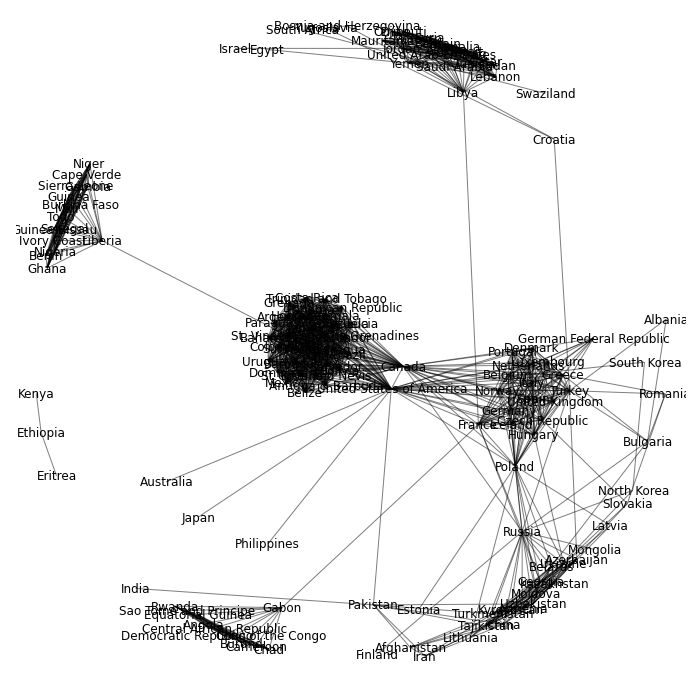

In [7]:
pos = nx.spring_layout(G, k=0.15, scale=8)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

#nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos)

ax.set_xlim(-0.25, 8.25)
ax.set_ylim(-0.25, 8.25)

In [8]:
names = {node: i for i, node in enumerate(G.nodes())}
mat = nx.to_numpy_matrix(G)

def get_tau(state_1, state_2, p_val=False):
    try:
        n1 = names[state_1]
        n2 = names[state_2]
        v1 = mat[n1]
        v2 = mat[n2]
        tau = scipy.stats.kendalltau(v1, v2)
    except:
        tau = (0, 0)
    if p_val:
        return tau
    else:
        return tau[0]

In [9]:
# How to normalize positions
positions = [get_tau("United States of America", actor)
             for actor in G.nodes()]
max_pos = max(positions)
min_pos = min(positions)
print(max_pos)
print(min_pos)

1.0
-0.324820421265


## NMC Data

In [10]:
nmc = pd.read_csv("/Users/dmasad/Data/COW/NMC_v4_0.csv")
nmc = nmc[nmc.year==start_year].copy()

In [11]:
# Add full names
system_members = pd.read_csv("/Users/dmasad/Data/COW/SystemMembership2011/states2011.csv")
system_members = system_members.drop_duplicates("ccode")
nmc = nmc.merge(system_members[["ccode", "statenme"]], how='left', on="ccode")

In [12]:
for node in G.nodes():
    if len(nmc[nmc.statenme==node]) == 0:
        print(node)

German Federal Republic


In [13]:
nmc[nmc.statenme=="Germany"]

,stateabb,ccode,year,irst,milex,milper,pec,tpop,upop,cinc,version,statenme
47,GMY,255,2004,46374,38263000,284,1181726,82501,25405,0.026612,4,Germany


# Build Model

In [14]:
class BDMActor(NegotiationActor):
    DecisionClass = BDM_Agent

In [15]:
# Build a dictionary of Actor data
ActorData = namedtuple("ActorData", ["name", "position", "capability"])
actor_data = defaultdict(ActorData)

In [16]:
for actor in G.nodes():
    position = get_tau("United States of America", actor, p_val=False)
    position = (position + abs(min_pos))/(max_pos - min_pos)
    name = actor if actor != "German Federal Republic" else "Germany"
    capability = nmc[nmc.statenme==name].cinc.values[0]
    actor_data[name] = ActorData(name, position, capability)

### Single Model Run

In [ ]:
agents = []
for actor in actor_data.values():
    new_agent = BDMActor(actor.name, actor.capability, actor.position, 1)
    agents.append(new_agent)

model = NegotiationModel(agents)

In [ ]:
for i in range(25):
    for agent in model.agents:
            agent.salience = random.random()
    model.step()

df = model.datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots(figsize=(12,4))
df.plot(ax=ax)
ax.set_ylim(0, 1)

### Top 50 agents

In [17]:
top_actors = nmc.sort("cinc", ascending=False).head(50)["statenme"].unique()

In [18]:
top_actors

array(['China', 'United States of America', 'India', 'Japan', 'Russia',
       'Germany', 'Brazil', 'South Korea', 'United Kingdom', 'France',
       'Italy', 'Ukraine', 'Turkey', 'Pakistan', 'Indonesia',
       'North Korea', 'Iran', 'Mexico', 'Spain', 'Canada', 'Egypt',
       'Saudi Arabia', 'Taiwan', 'Vietnam', 'Bangladesh', 'Thailand',
       'Nigeria', 'Myanmar', 'Poland', 'Australia', 'South Africa',
       'Netherlands', 'Colombia', 'Iraq', 'Philippines', 'Sweden',
       'Algeria', 'Argentina', 'Belgium', 'Venezuela', 'Syria', 'Morocco',
       'Malaysia', 'Ethiopia', 'Greece', 'Israel', 'Romania',
       'Democratic Republic of the Congo', 'Kazakhstan', 'Chile'], dtype=object)

In [21]:
agents = []
for name in top_actors:
    if name in actor_data:
        actor = actor_data[name]
        new_agent = BDMActor(actor.name, actor.capability, actor.position, 1)
        agents.append(new_agent)
    else:
        print(name)

model = NegotiationModel(agents)

Indonesia
Taiwan
Vietnam
Bangladesh
Thailand
Myanmar
Sweden
Malaysia


(0, 1)

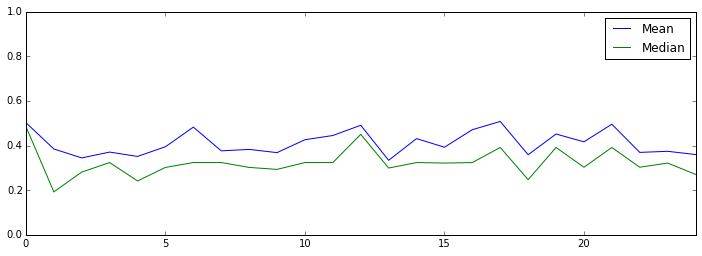

In [22]:
for i in range(25):
    for agent in model.agents:
            agent.salience = random.random()
    model.step()

df = model.datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots(figsize=(12,4))
df.plot(ax=ax)
ax.set_ylim(0, 1)

In [23]:
model.log.get_events(timestamp=20, action="Attack")

[Event(source='United States of America', target='Saudi Arabia', timestamp=20, action='Attack'),
 Event(source='Saudi Arabia', target='United States of America', timestamp=20, action='Attack')]

### Multiple iterations

In [19]:
agents = []
for name in top_actors:
    if name in actor_data:
        actor = actor_data[name]
        new_agent = BDMActor(actor.name, actor.capability, actor.position, 1)
    else:
        capability = nmc[nmc.statenme==name].cinc.values[0]
        pos = 0.5 + random.normalvariate(0, 0.1)
        new_agent = BDMActor(name, capability, 0.5, 1)

    new_agent.decision_model.Q = 0.5
    new_agent.decision_model.T = 0.5
    agents.append(new_agent)
    
model = NegotiationModel(agents)

In [53]:
all_models = []
for i in range(100):
    new_model = copy.deepcopy(model)
    for agent in new_model.agents:
            agent.salience = random.random()
    # Run the model:
    for j in range(25):
        new_model.step()
    
    all_models.append(new_model)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(0, 1)

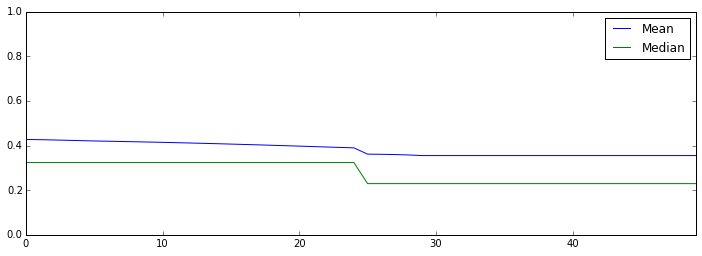

In [54]:
df = all_models[-1].datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots(figsize=(12,4))
df.plot(ax=ax)
ax.set_ylim(0, 1)

In [55]:
conflict_dyads = Counter()
conflict_models = defaultdict(set)

for i, model in enumerate(all_models):
    for event in model.log.get_events(action="Attack"):
        source = event.source
        target = event.target
        dyad = (source, target)
        conflict_dyads[dyad] += 1
        conflict_models[dyad].add(i)

conflict_models = {k: len(v) for k, v in conflict_models.items()}        
        
# Fill in zeroes
for source, target in permutations(top_actors, 2):
    dyad = (source, target)
    if dyad not in conflict_dyads:
        conflict_dyads[dyad] = 0
    if dyad not in conflict_models:
        conflict_models[dyad] = 0

## Get ICEWS Data

Data prepared in [6.05 ICEWS Aggregation](http://localhost:8888/notebooks/Programming/ConflictModel/negotiation_model/6.05%20ICEWS%20Aggregation.ipynb)

In [56]:
icews = pd.read_csv("Negative_Dyads_2005-2006.csv")
icews = icews[["Source_Country", "Target_Country", "Event_ID"]]
icews.rename(columns={"Event_ID": "Count"}, inplace=True)

In [57]:
icews.head()

,Source_Country,Target_Country,Count
0,Afghanistan,Australia,2
1,Afghanistan,Canada,7
2,Afghanistan,Denmark,2
3,Afghanistan,Germany,2
4,Afghanistan,India,2


In [58]:
icews.replace("Democratic Republic of Congo", "Democratic Republic of the Congo", inplace=True)
icews.replace("Russian Federation", "Russia", inplace=True)
icews.replace("United States", "United States of America", inplace=True)

# Compare

In [59]:
model_conflicts = pd.DataFrame({"Model_Conflicts": dict(conflict_dyads),
                               "Models_with_Conflicts": conflict_models})
model_conflicts.reset_index(inplace=True)
model_conflicts.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

In [60]:
model_conflicts.head()

,Source_Country,Target_Country,Model_Conflicts,Models_with_Conflicts
0,Algeria,Argentina,14,1
1,Algeria,Australia,0,0
2,Algeria,Bangladesh,0,0
3,Algeria,Belgium,0,0
4,Algeria,Brazil,0,0


In [61]:
df = model_conflicts.merge(icews, how="left", on=["Source_Country", "Target_Country"])
df.rename(columns={"Count": "ICEWS_Count"}, inplace=True)
df.fillna(0, inplace=True)

In [62]:
df.head()

,Source_Country,Target_Country,Model_Conflicts,Models_with_Conflicts,ICEWS_Count
0,Algeria,Argentina,14,1,0
1,Algeria,Australia,0,0,0
2,Algeria,Bangladesh,0,0,0
3,Algeria,Belgium,0,0,0
4,Algeria,Brazil,0,0,0


In [63]:
import statsmodels.api as sm

In [64]:
df["Const."] = 1

In [65]:
lm = sm.OLS(df["ICEWS_Count"], df[["Const.", "Model_Conflicts"]])
fit = lm.fit()

In [66]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:            ICEWS_Count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.529
Date:                Wed, 02 Sep 2015   Prob (F-statistic):            0.00353
Time:                        01:29:57   Log-Likelihood:                -10445.
No. Observations:                2450   AIC:                         2.089e+04
Df Residuals:                    2448   BIC:                         2.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Const.              2.8146      0.348     

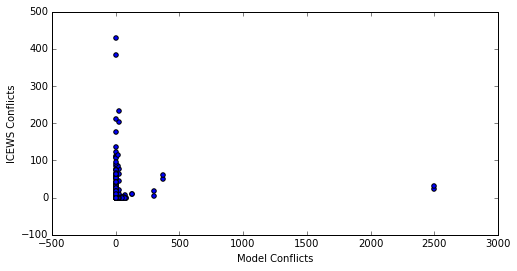

In [67]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(df.Model_Conflicts, df.ICEWS_Count)
ax.set_xlabel("Model Conflicts")
ax.set_ylabel("ICEWS Conflicts")
#ax.set_xlim(-5, 100)

In [68]:
df.corr(method="spearman")

,Model_Conflicts,Models_with_Conflicts,ICEWS_Count,Const.
Model_Conflicts,1.000000,0.999669,0.087622,NaN
Models_with_Conflicts,0.999669,1.000000,0.087261,NaN
ICEWS_Count,0.087622,0.087261,1.000000,NaN
Const.,NaN,NaN,NaN,NaN


In [69]:
df.corr()

,Model_Conflicts,Models_with_Conflicts,ICEWS_Count,Const.
Model_Conflicts,1.000000,0.997668,0.058925,NaN
Models_with_Conflicts,0.997668,1.000000,0.060462,NaN
ICEWS_Count,0.058925,0.060462,1.000000,NaN
Const.,NaN,NaN,NaN,NaN


### At least N events

In [70]:
df["ICEWS_Dummy"] = 0
df["ICEWS_Dummy"][df.ICEWS_Count > 5] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [71]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Model_Conflicts"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.256266
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2448
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                 0.02383
Time:                        01:29:58   Log-Likelihood:                -627.85
converged:                       True   LL-Null:                       -643.18
                                        LLR p-value:                 3.084e-08
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Const.             -2.5896      0.079    -32.590      0.000        -2.745    -2.434
Model_Conflict

In [72]:
pd.crosstab(df.ICEWS_Dummy, df.Model_Conflicts)

Model_Conflicts,0,1,2,3,4,5,6,13,14,17,...,50,51,61,66,73,81,125,300,373,2500
ICEWS_Dummy,,,,,,,,,,,,,,,,,,,,,
0,2143,38,7,6,2,2,3,2,2,2,...,4,2,2,2,1,2,0,1,0,0
1,155,4,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,2,1,2,2


In [73]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Models_with_Conflicts"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.256733
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2448
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                 0.02205
Time:                        01:29:58   Log-Likelihood:                -629.00
converged:                       True   LL-Null:                       -643.18
                                        LLR p-value:                 1.005e-07
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Const.                   -2.5943      0.080    -32.556      0.000        -2.751    -2.

In [74]:
df["Model_Dummy"] = 0
df["Model_Dummy"][df.Model_Conflicts > 0] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [75]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Model_Dummy"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.259402
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2448
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                 0.01189
Time:                        01:29:59   Log-Likelihood:                -635.53
converged:                       True   LL-Null:                       -643.18
                                        LLR p-value:                 9.223e-05
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Const.         -2.6265      0.083    -31.578      0.000        -2.790    -2.464
Model_Dummy     1.0012    

In [76]:
df["Model_Dummy"] = 0
df["Model_Dummy"][df.Models_with_Conflicts > 0] = 1

logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Model_Dummy"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.259402
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2448
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                 0.01189
Time:                        01:30:00   Log-Likelihood:                -635.53
converged:                       True   LL-Null:                       -643.18
                                        LLR p-value:                 9.223e-05
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Const.         -2.6265      0.083    -31.578      0.000        -2.790    -2.464
Model_Dummy     1.0012    

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


### Is it better than just using $\Delta$Taus?

In [77]:
dyad_taus = {}
for i, row in df.iterrows():
    source = row.Source_Country
    target = row.Target_Country
    tau = get_tau(source, target)
    dyad_taus[(source, target)] = tau

In [78]:
taus = pd.Series(dyad_taus).reset_index()
taus.rename(columns={"level_0": "Source_Country", 
                     "level_1": "Target_Country",
                     0: "Tau"}, inplace=True)

In [79]:
df = df.merge(taus, how='left', on=["Source_Country", "Target_Country"])

In [80]:
df["Tau_Dummy"] = 0
df["Tau_Dummy"][df.Tau != 0] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [81]:
lm = sm.OLS(df["ICEWS_Count"], df[["Const.", "Tau"]])
fit = lm.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:            ICEWS_Count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     17.01
Date:                Wed, 02 Sep 2015   Prob (F-statistic):           3.84e-05
Time:                        01:30:05   Log-Likelihood:                -10440.
No. Observations:                2450   AIC:                         2.088e+04
Df Residuals:                    2448   BIC:                         2.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Const.         2.6281      0.352      7.475      0.0

In [82]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Tau_Dummy", "Tau"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.248728
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2447
Method:                           MLE   Df Model:                            2
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                 0.05254
Time:                        01:30:05   Log-Likelihood:                -609.38
converged:                       True   LL-Null:                       -643.18
                                        LLR p-value:                 2.103e-15
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Const.        -3.4227      0.212    -16.153      0.000        -3.838    -3.007
Tau_Dummy      0.9530      0.

In [83]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Tau", "Tau_Dummy", "Model_Conflicts"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.242174
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2446
Method:                           MLE   Df Model:                            3
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                 0.07751
Time:                        01:30:05   Log-Likelihood:                -593.33
converged:                       True   LL-Null:                       -643.18
                                        LLR p-value:                 1.797e-21
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Const.             -3.4299      0.212    -16.186      0.000        -3.845    -3.015
Tau           

In [84]:
logit = sm.Logit(df["Model_Dummy"], df[["Const.", "Tau"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.230828
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Model_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2448
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Sep 2015   Pseudo R-squ.:                0.007389
Time:                        01:30:05   Log-Likelihood:                -565.53
converged:                       True   LL-Null:                       -569.74
                                        LLR p-value:                  0.003711
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Const.        -2.6989      0.084    -32.145      0.000        -2.863    -2.534
Tau           -1.1543      0.